# Лаборатоная работа №2.
## Шорсткая А.А. группа 3372

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import scipy.stats
import seaborn as sns
import random
from sklearn.cluster import KMeans
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
import plotly.graph_objects as go
import plotly.io as pio
import warnings
warnings.filterwarnings('ignore')

pio.renderers.default = 'jupyterlab'

### Добавляем новый столбец
Productivity_Score(1-10) - числовой, субъективная оценка своей продуктивности респондентом

Правила для генерации новый данных:

Базовый балл: 6

Влияние данных из сущуствующих столбцов на новые данные:
- Высокий сон (sleep_hours >= 7): +2 балла, либо -2 в противном случае
- Высокое время на подготовку (hours_studied >= 7): +2 балла, либо -2 в противном случае
- Высокий процент посещаемости (attendance_percent > 80): +1 балла, либо -1 в противном случае
- Высокий балл за экзамен (exam_score >= 80): +1 балла, либо -1 в противном случае

Так же добавим 10% шанс на то, что новых данных будут существовать выбросы, либо же каждая 91 ячейка будет содержать выброс

In [2]:
df = pd.read_csv('student_exam_scores.csv')

counter = 0

def calculate_productivity_score(row):
    base_score = 6
    
    
    if row['sleep_hours'] >= 7:
        base_score += 2 
    elif row['sleep_hours'] <= 5:
        base_score -= 2

    if row['hours_studied'] >= 8:
        base_score += 2
    elif row['hours_studied'] <= 5:
        base_score -= 2
    
    if row['attendance_percent'] >= 80:
        base_score += 1 
    elif row['attendance_percent'] < 60:
        base_score -= 1 

    if row['exam_score'] >= 75:
        base_score += 1
    elif row['exam_score'] <= 50:
        base_score -= 1
    
    base_score = max(1, min(10, base_score))

    global counter
    counter += 1
    
    if random.random() < 0.15 or counter % 100 == 0:
        outlier_type = random.choice(['extreme_low', 'extreme_high', 'inconsistent'])
        
        if outlier_type == 'extreme_low':
            return -5
        elif outlier_type == 'extreme_high':
            return 16
        else:
            if base_score > 5:
                return -5
            else:
                return 16
    
    return base_score
    

df['productivity_score'] = df.apply(calculate_productivity_score, axis=1)

df.to_csv('student_exam_scores_with_productivity.csv', index=False)

print(df.head())

  student_id  hours_studied  sleep_hours  attendance_percent  previous_scores  \
0       S001            8.0          8.8                72.1               45   
1       S002            1.3          8.6                60.7               55   
2       S003            4.0          8.2                73.7               86   
3       S004            3.5          4.8                95.1               66   
4       S005            9.1          6.4                89.8               71   

   exam_score  productivity_score  
0        30.2                   9  
1        25.0                   5  
2        35.8                   5  
3        34.0                   2  
4        40.3                   8  


### Нахождение среднего и СКО для productivity_score

In [3]:
productivity_mid = df['productivity_score'].mean()
productivity_sd = df['productivity_score'].std()


print(f'productivity_score: среднее = {productivity_mid}, СКО = {productivity_sd}')

productivity_score: среднее = 5.34, СКО = 4.505094826636275


### Построение гристорамм распределения для productivity_score

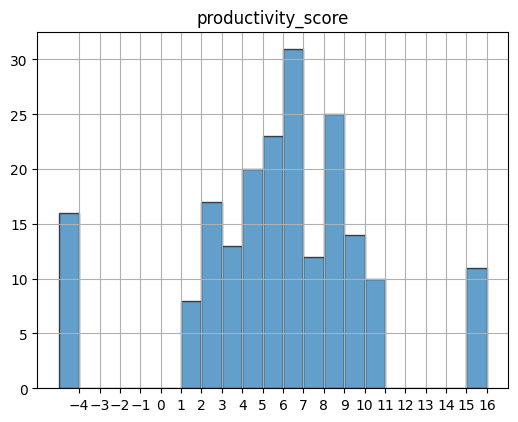

In [4]:
bins_config = {
    'productivity_score': range(-5, 17)
}

fig, axes = plt.subplots(3, 3, figsize=(15, 12))
axes = axes.ravel()

columns = ['productivity_score']

for i, col in enumerate(columns):
    if col in bins_config:
        bins = bins_config[col]
        df[col].hist(bins=bins, ax=axes[i], edgecolor='black', alpha=0.7)
        axes[i].set_title(col)
        
        if isinstance(bins, range):
            axes[i].set_xticks(list(bins)[1:])
    
for j in range(len(columns), len(axes)):
    fig.delaxes(axes[j])

plt.tight_layout()
plt.show()

### Обнаружение выбросов методом IQR

In [5]:
def detect_outliers_iqr(data):
    Q1 = data.quantile(0.25)
    Q3 = data.quantile(0.75)
    
    IQR = Q3 - Q1
    
    lower_bound = Q1 - 1.5 * IQR
    upper_bound = Q3 + 1.5 * IQR
    
    return (data < lower_bound) | (data > upper_bound)


hours_studied_out = detect_outliers_iqr(df['hours_studied'])
sleep_hours_out = detect_outliers_iqr(df['sleep_hours'])
attendance_percent_out = detect_outliers_iqr(df['attendance_percent'])
previous_scores_out = detect_outliers_iqr(df['previous_scores'])
exam_score_out = detect_outliers_iqr(df['exam_score'])
productivity_out = detect_outliers_iqr(df['productivity_score'])

print(f'Кол-во выбросов в hours_studied = {sum(hours_studied_out)}')
print(f'Кол-во выбросов в sleep_hours = {sum(sleep_hours_out)}')
print(f'Кол-во выбросов в attendance_percent = {sum(attendance_percent_out)}')
print(f'Кол-во выбросов в previous_scores = {sum(previous_scores_out)}')
print(f'Кол-во выбросов в exam_score = {sum(exam_score_out)}')
print(f'Кол-во выбросов в productivity_score = {sum(productivity_out)}')

Кол-во выбросов в hours_studied = 0
Кол-во выбросов в sleep_hours = 0
Кол-во выбросов в attendance_percent = 0
Кол-во выбросов в previous_scores = 0
Кол-во выбросов в exam_score = 0
Кол-во выбросов в productivity_score = 27


### Визуализируем выбросы с помощью диаграммы рассеивания и коробчатых диаграмм

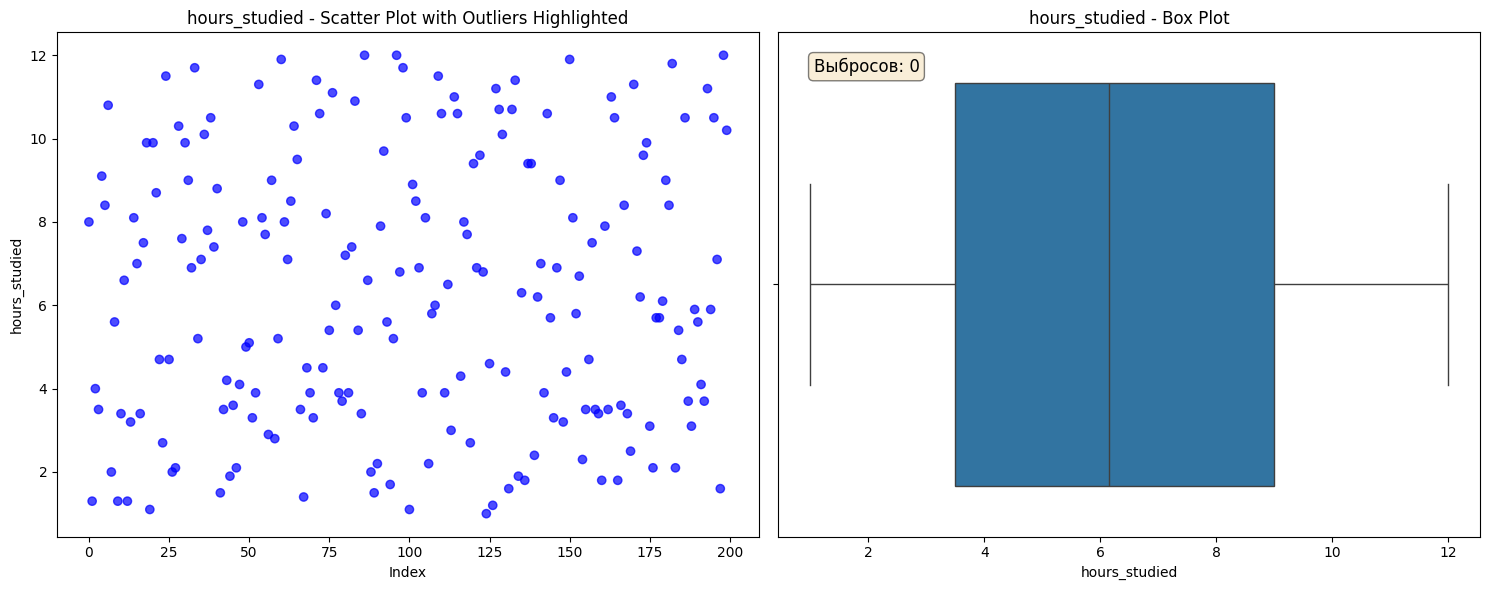

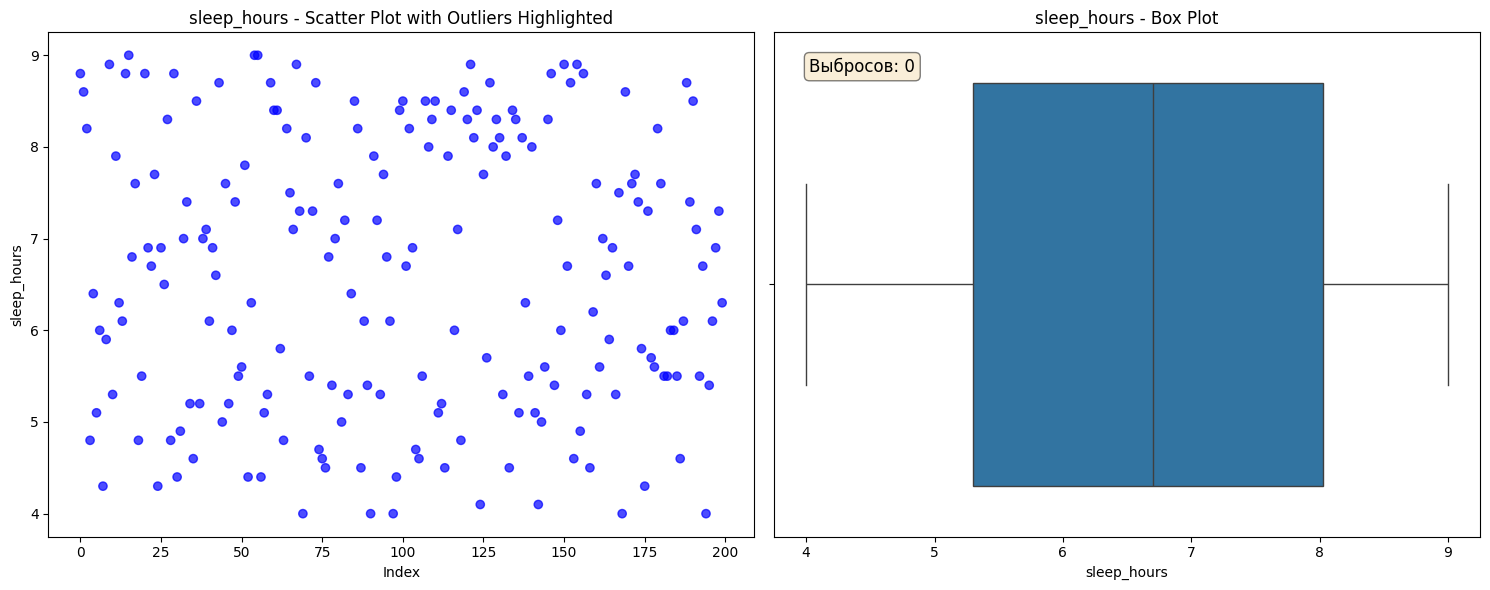

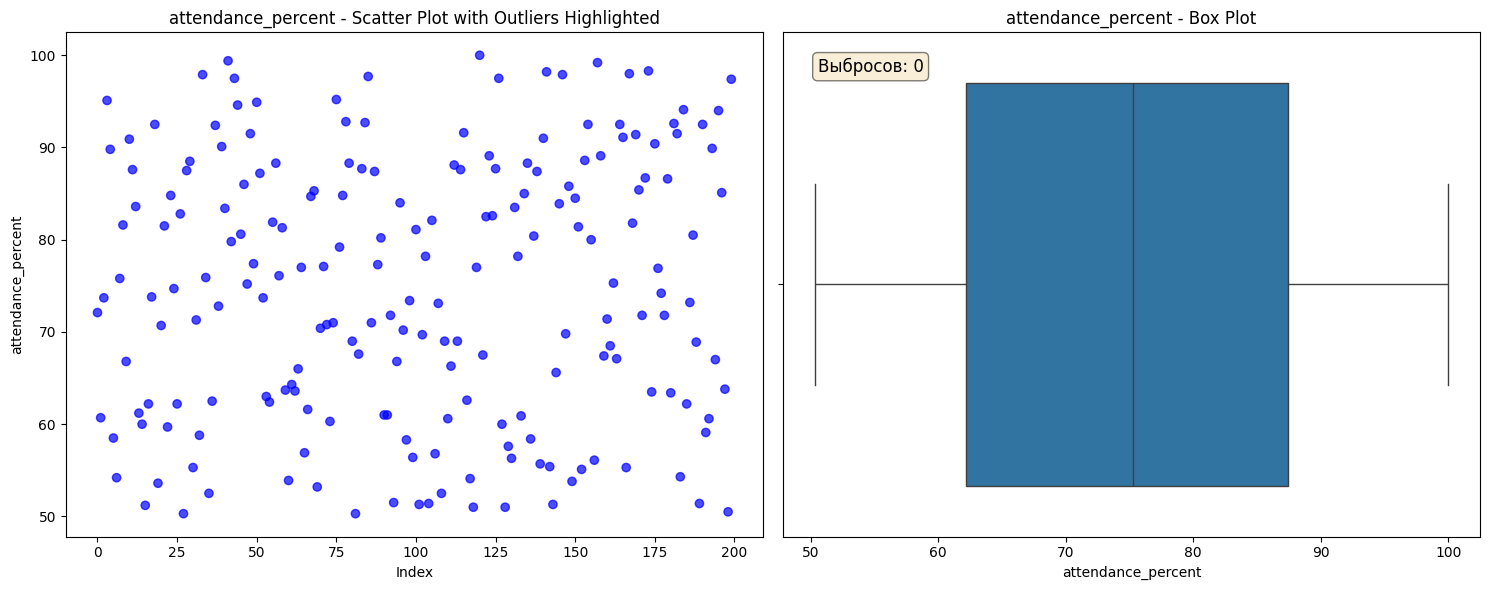

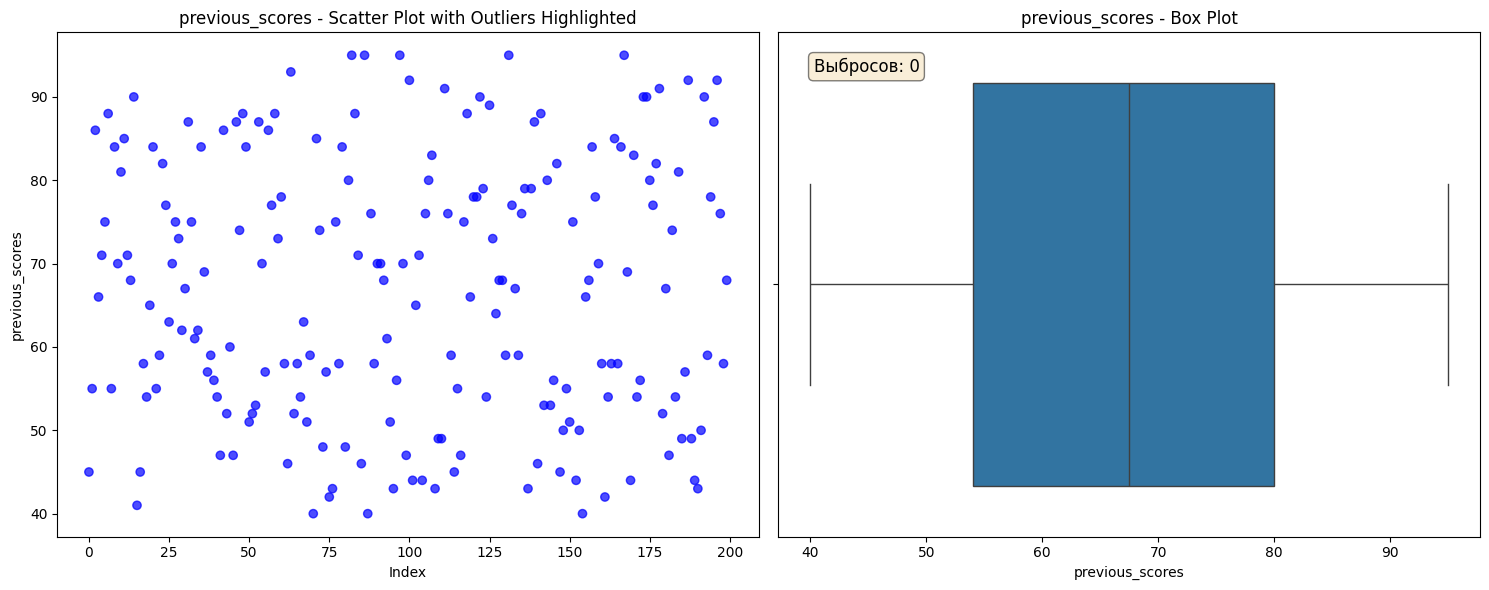

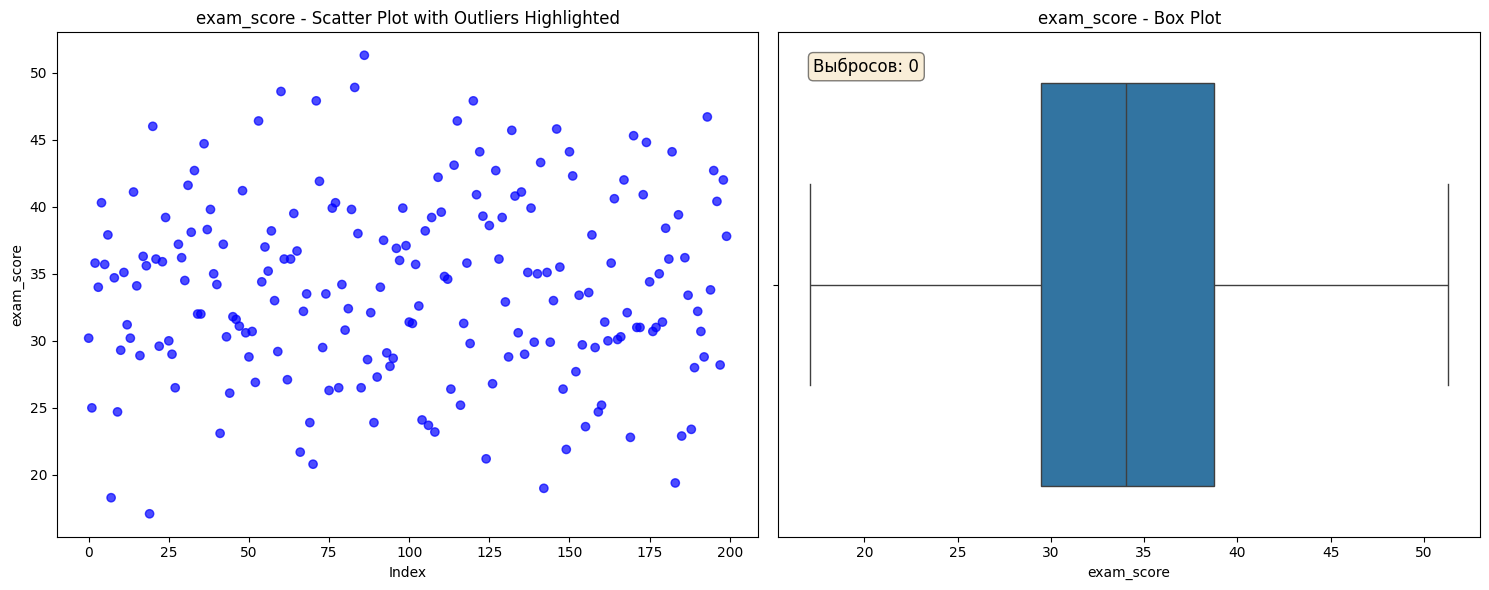

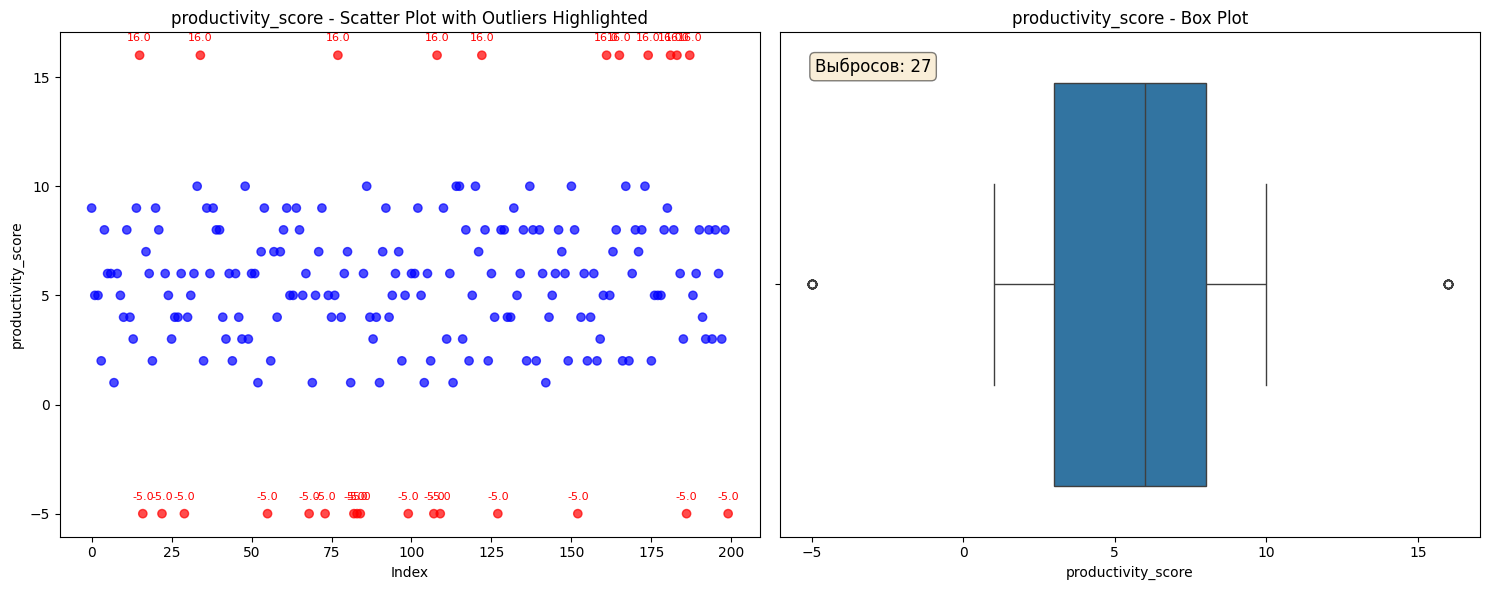


Статистика выбросов для productivity_score:
Количество: 27
Значения: [16 -5 -5 -5 16 -5 -5 -5 16 -5 -5 -5 -5 -5 16 -5 16 -5 -5 16 16 16 16 16
 -5 16 -5]
Индексы: [15, 16, 22, 29, 34, 55, 68, 73, 77, 82, 83, 84, 99, 107, 108, 109, 122, 127, 152, 161, 165, 174, 181, 183, 186, 187, 199]
----------------------------------------------------------------------------------------------------


In [6]:
attributes = [
    ('hours_studied', hours_studied_out),
    ('sleep_hours',sleep_hours_out),
    ('attendance_percent', attendance_percent_out),
    ('previous_scores', previous_scores_out),
    ('exam_score', exam_score_out),
    ('productivity_score', productivity_out)
]

for col, outliers in attributes:
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 6))
    
    data = df[col]
    
    colors = ['blue' if not x else 'red' for x in outliers]
    ax1.scatter(range(len(data)), data, c=colors, alpha=0.7)
    ax1.set_title(f'{col} - Scatter Plot with Outliers Highlighted')
    ax1.set_xlabel('Index')
    ax1.set_ylabel(col)
    
    outlier_indices = outliers[outliers].index
    for idx in outlier_indices:
        ax1.annotate(f'{data[idx]:.1f}', 
                    (idx, data[idx]),
                    textcoords="offset points",
                    xytext=(0,10),
                    ha='center',
                    fontsize=8,
                    color='red')
    
    sns.boxplot(x=data, ax=ax2)
    ax2.set_title(f'{col} - Box Plot')
    ax2.set_xlabel(col)
    
    num_outliers = sum(outliers)
    ax2.text(0.05, 0.95, f'Выбросов: {num_outliers}', 
             transform=ax2.transAxes, fontsize=12,
             verticalalignment='top',
             bbox=dict(boxstyle='round', facecolor='wheat', alpha=0.5))
    
    plt.tight_layout()
    plt.show()
    
    if num_outliers > 0:
        outlier_data = data[outliers]
        print(f"\nСтатистика выбросов для {col}:")
        print(f"Количество: {num_outliers}")
        print(f"Значения: {outlier_data.values}")
        print(f"Индексы: {outlier_data.index.tolist()}")
        print("-" * 100)

### Удалим те строки, где встречаются выбросы

In [7]:
numeric_columns = [
    'hours_studied', 'sleep_hours', 'attendance_percent',
    'previous_scores', 'exam_score', 'productivity_score'
]

outlier_mask = pd.Series([False] * len(df))

for column in numeric_columns:
    column_outliers = detect_outliers_iqr(df[column])
    outlier_mask = outlier_mask | column_outliers
    print(f'Кол-во выбросов в {column} = {sum(column_outliers)}')

df_cleaned = df[~outlier_mask]

df_cleaned.to_csv('student_exam_scores_with_productivity_cleaned.csv', index=False)

print(f"\nИсходный размер датасета: {df.shape}")
print(f"Размер датасета после удаления выбросов: {df_cleaned.shape}")
print(f"Удалено строк с выбросами: {sum(outlier_mask)}")
print(f"Осталось строк: {len(df_cleaned)}")

print("\nСтатистика после удаления выбросов:")
for column in numeric_columns:
    print(f"{column}: среднее = {df_cleaned[column].mean():.3f}, СКО = {df_cleaned[column].std():.3f}")

Кол-во выбросов в hours_studied = 0
Кол-во выбросов в sleep_hours = 0
Кол-во выбросов в attendance_percent = 0
Кол-во выбросов в previous_scores = 0
Кол-во выбросов в exam_score = 0
Кол-во выбросов в productivity_score = 27

Исходный размер датасета: (200, 7)
Размер датасета после удаления выбросов: (173, 7)
Удалено строк с выбросами: 27
Осталось строк: 173

Статистика после удаления выбросов:
hours_studied: среднее = 6.219, СКО = 3.278
sleep_hours: среднее = 6.542, СКО = 1.505
attendance_percent: среднее = 75.136, СКО = 14.263
previous_scores: среднее = 67.503, СКО = 15.315
exam_score: среднее = 33.745, СКО = 6.800
productivity_score: среднее = 5.618, СКО = 2.488


### Работа с K-Mean

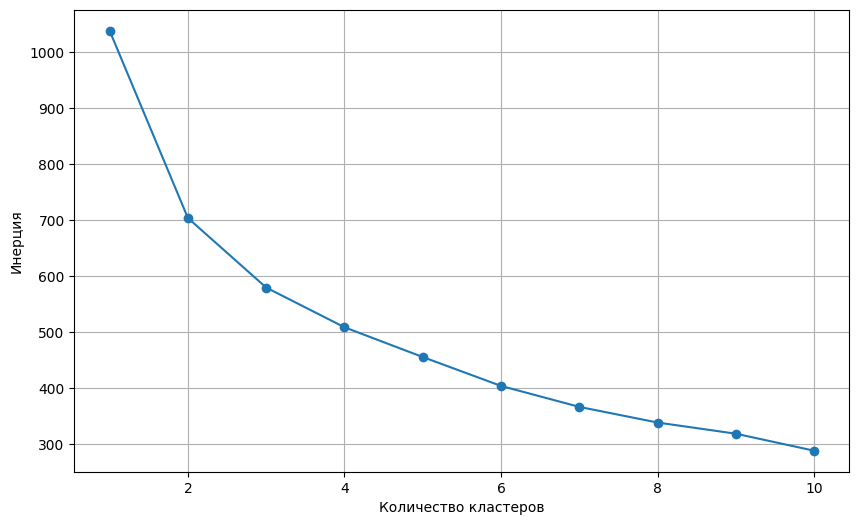

In [8]:
scaler = StandardScaler()
X_scaled = scaler.fit_transform(df_cleaned[numeric_columns])

wcss = []
for i in range(1, 11):
    kmeans = KMeans(n_clusters=i, random_state=42, n_init=10)
    kmeans.fit(X_scaled)
    wcss.append(kmeans.inertia_)

plt.figure(figsize=(10, 6))
plt.plot(range(1, 11), wcss, marker='o')
plt.xlabel('Количество кластеров')
plt.ylabel('Инерция')
plt.grid(True)
plt.show()

<Figure size 1500x1200 with 0 Axes>

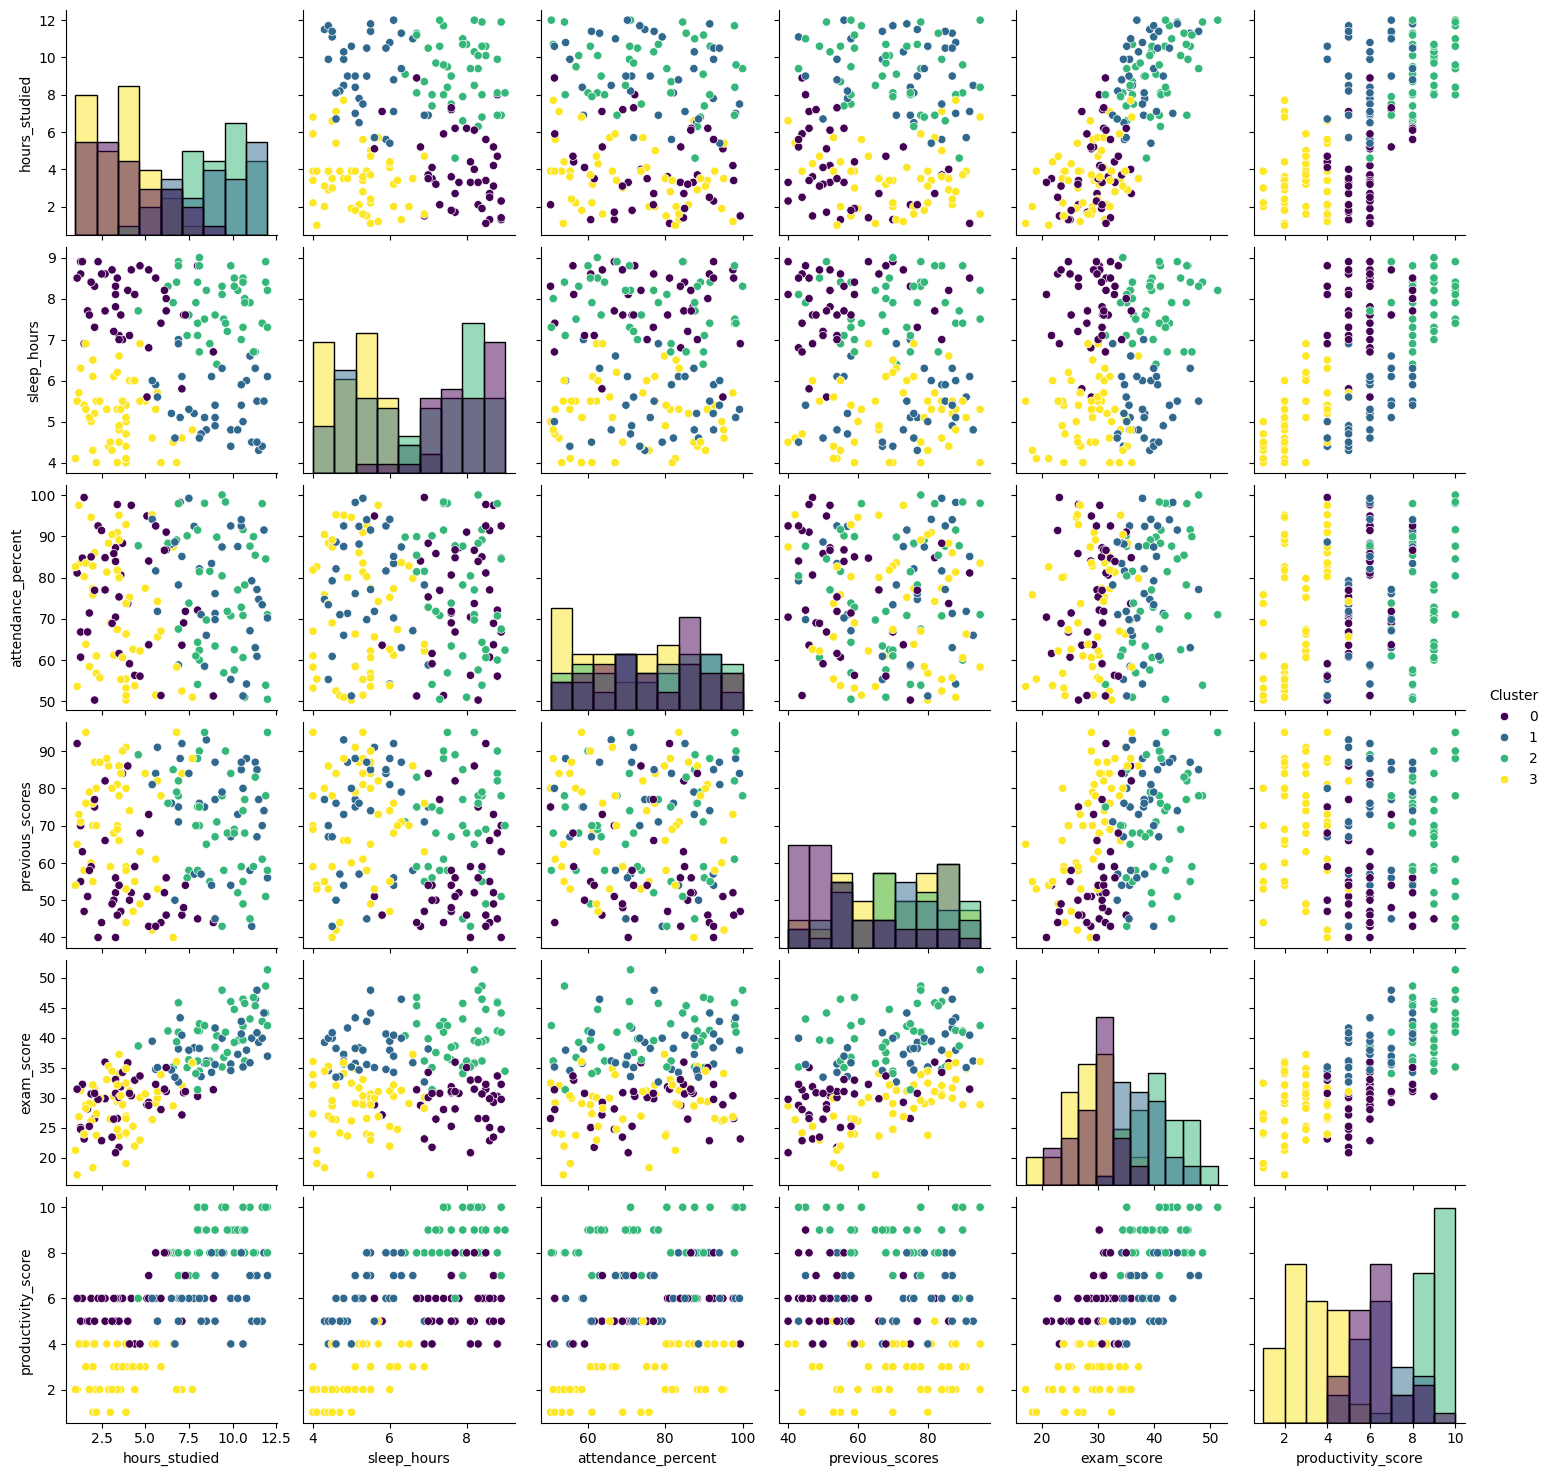

In [9]:
kmeans = KMeans(n_clusters=4, random_state=42, n_init=10)
clusters = kmeans.fit_predict(X_scaled)
df_cleaned['Cluster'] = clusters

plt.figure(figsize=(15, 12))
sns.pairplot(df_cleaned, vars=numeric_columns, hue='Cluster', palette='viridis', diag_kind='hist')
plt.show()


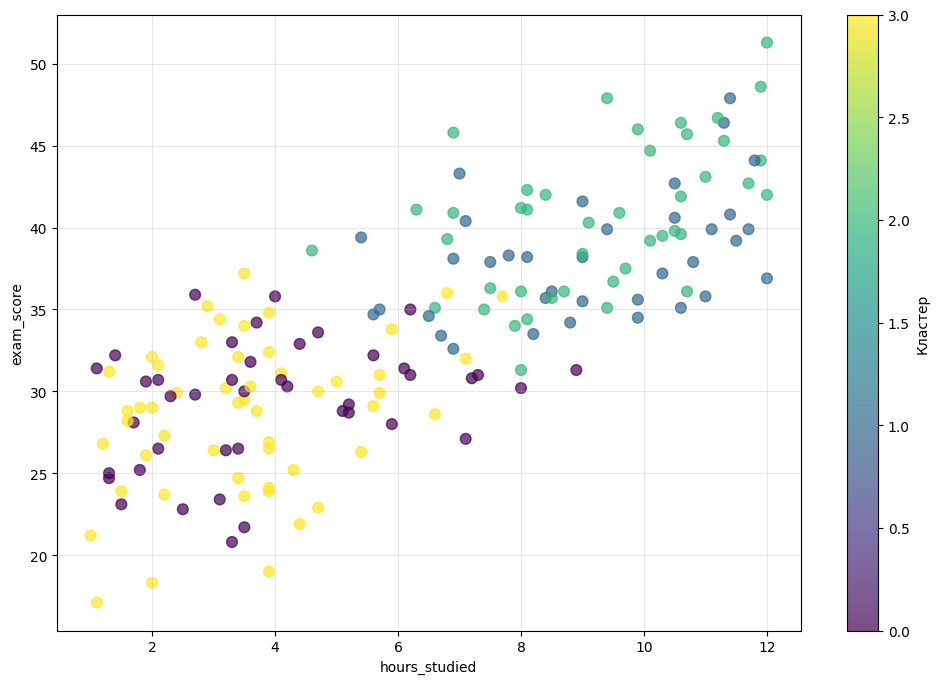

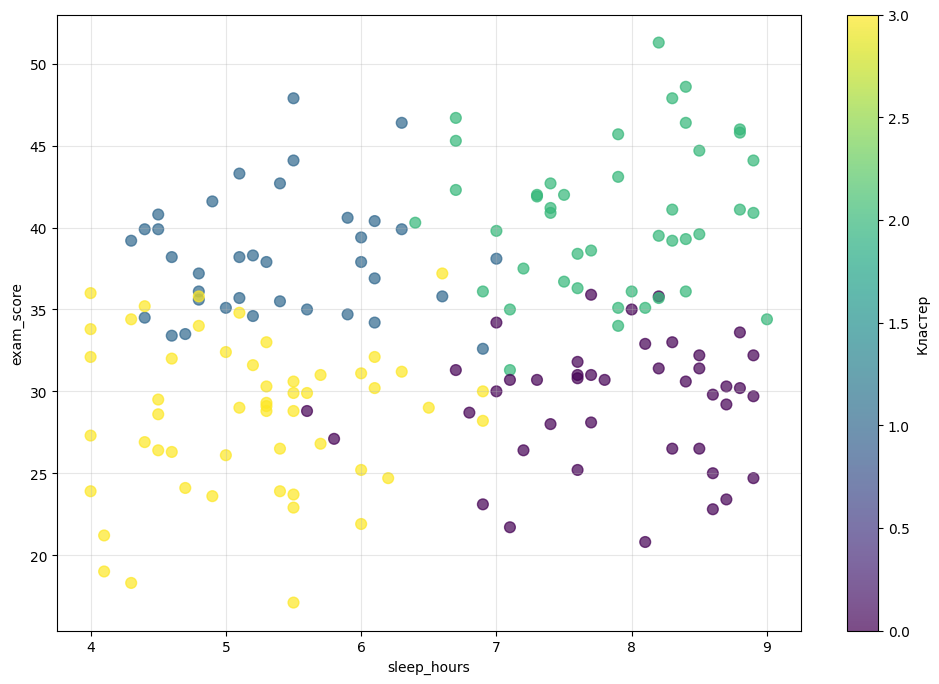

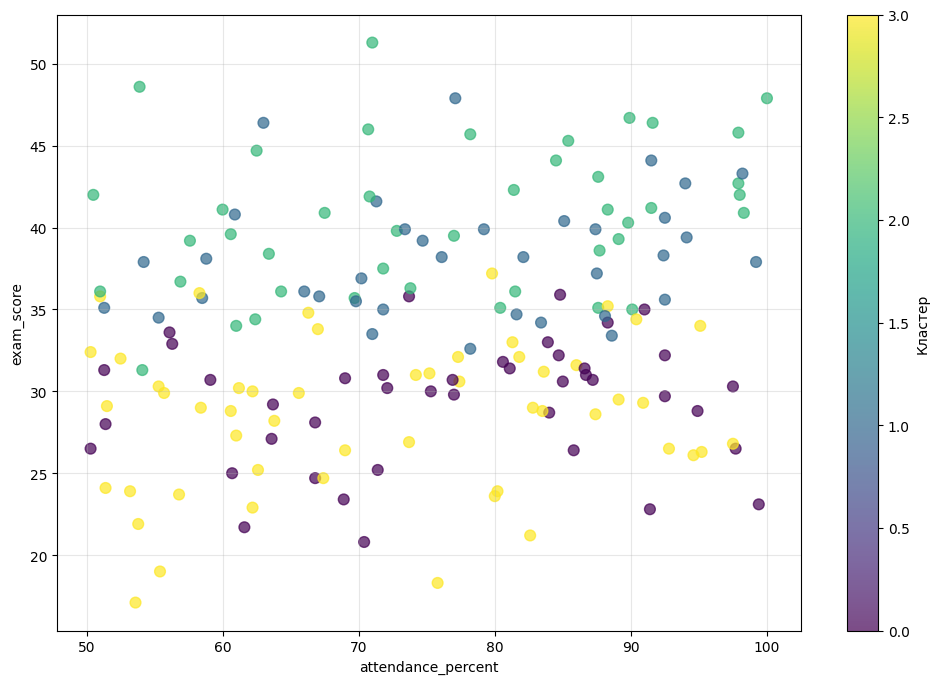

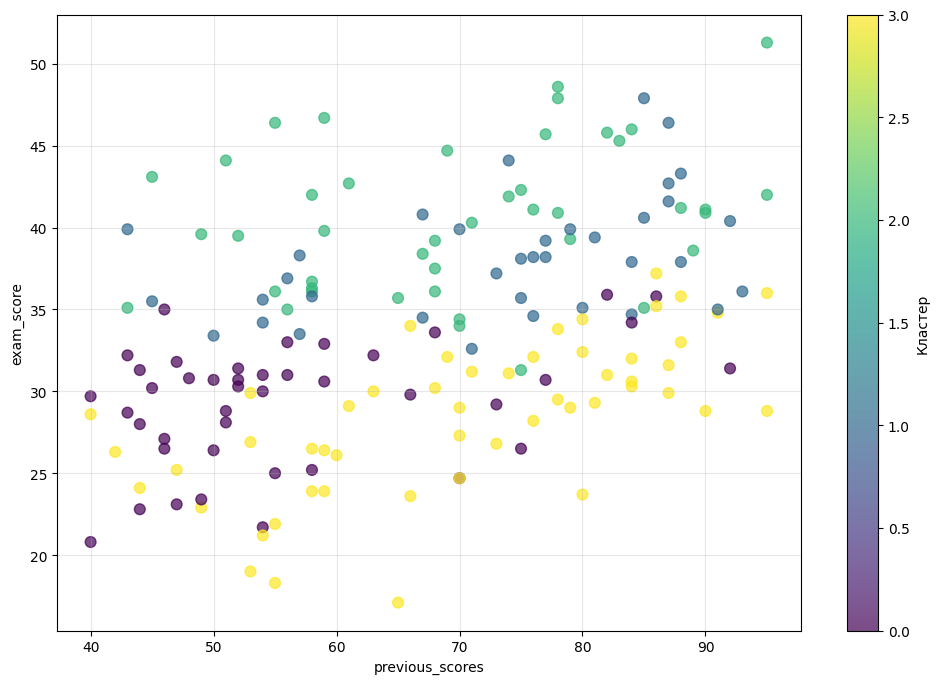

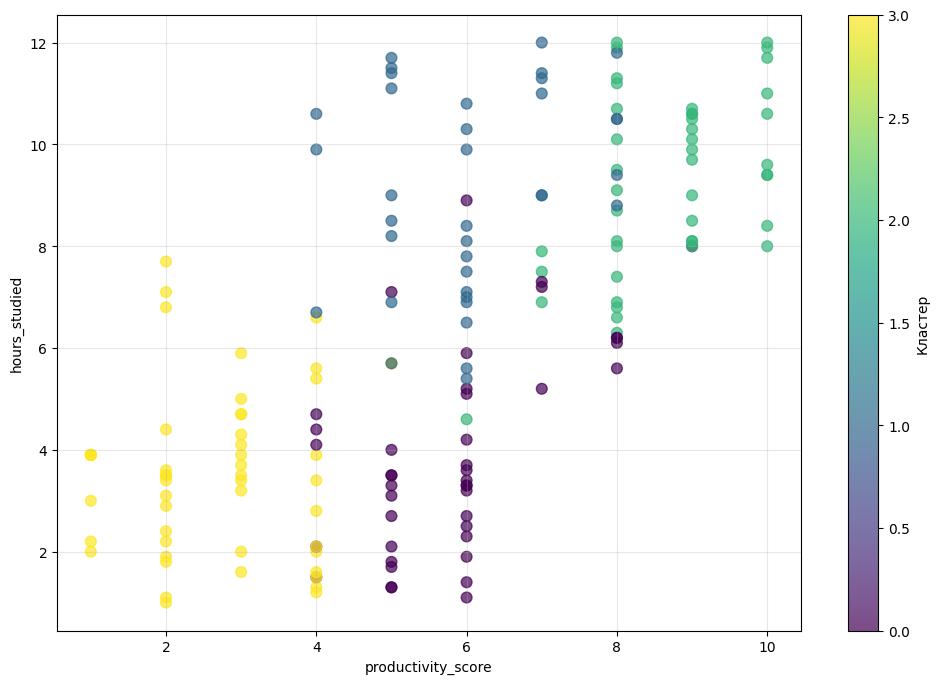

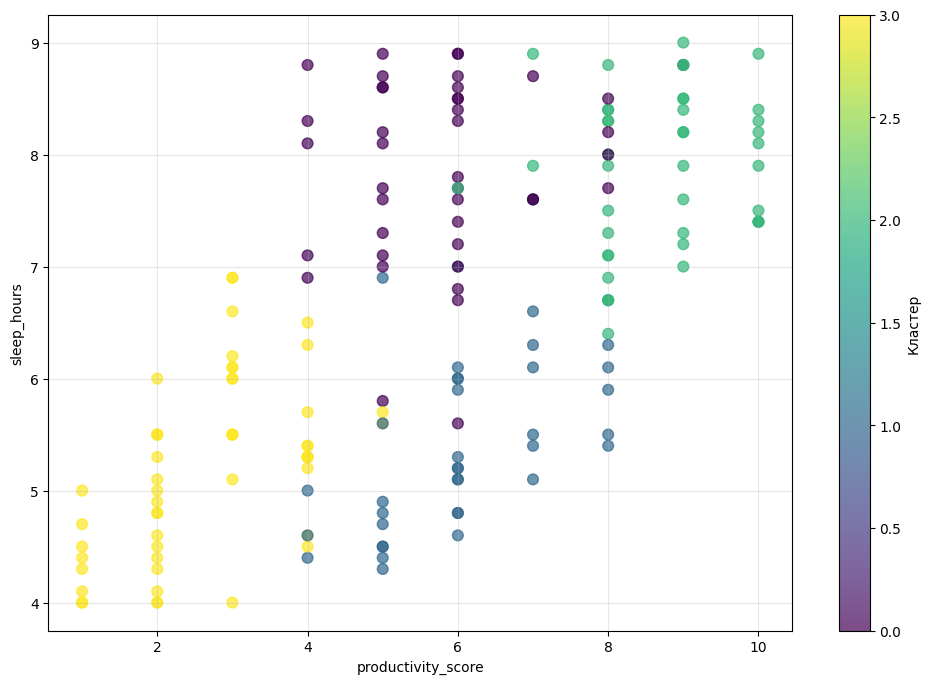

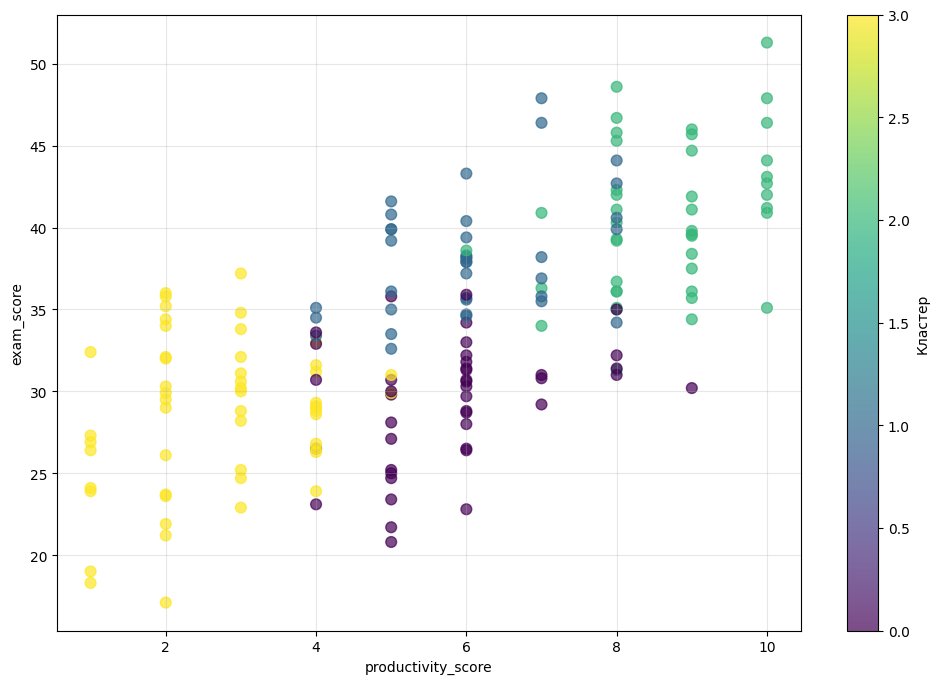

In [10]:
key_pairs = [
    ('hours_studied', 'exam_score'),
    ('sleep_hours', 'exam_score'),
    ('attendance_percent', 'exam_score'),
    ('previous_scores', 'exam_score'),
    ('productivity_score', 'hours_studied'),
    ('productivity_score', 'sleep_hours'),
    ('productivity_score', 'exam_score'),
]

plt.figure(figsize=(12, 8))
scatter = plt.scatter(df_cleaned['hours_studied'], 
                     df_cleaned['exam_score'], 
                     c=df_cleaned['Cluster'], 
                     cmap='viridis', 
                     alpha=0.7, 
                     s=60)
plt.colorbar(scatter, label='Кластер')
plt.xlabel('hours_studied')
plt.ylabel('exam_score')
plt.grid(True, alpha=0.3)
plt.show()

plt.figure(figsize=(12, 8))
scatter = plt.scatter(df_cleaned['sleep_hours'], 
                     df_cleaned['exam_score'], 
                     c=df_cleaned['Cluster'], 
                     cmap='viridis', 
                     alpha=0.7, 
                     s=60)
plt.colorbar(scatter, label='Кластер')
plt.xlabel('sleep_hours')
plt.ylabel('exam_score')
plt.grid(True, alpha=0.3)
plt.show()

plt.figure(figsize=(12, 8))
scatter = plt.scatter(df_cleaned['attendance_percent'], 
                     df_cleaned['exam_score'], 
                     c=df_cleaned['Cluster'], 
                     cmap='viridis', 
                     alpha=0.7, 
                     s=60)
plt.colorbar(scatter, label='Кластер')
plt.xlabel('attendance_percent')
plt.ylabel('exam_score')
plt.grid(True, alpha=0.3)
plt.show()

plt.figure(figsize=(12, 8))
scatter = plt.scatter(df_cleaned['previous_scores'], 
                     df_cleaned['exam_score'], 
                     c=df_cleaned['Cluster'], 
                     cmap='viridis', 
                     alpha=0.7, 
                     s=60)
plt.colorbar(scatter, label='Кластер')
plt.xlabel('previous_scores')
plt.ylabel('exam_score')
plt.grid(True, alpha=0.3)
plt.show()

plt.figure(figsize=(12, 8))
scatter = plt.scatter(df_cleaned['productivity_score'], 
                     df_cleaned['hours_studied'], 
                     c=df_cleaned['Cluster'], 
                     cmap='viridis', 
                     alpha=0.7, 
                     s=60)
plt.colorbar(scatter, label='Кластер')
plt.xlabel('productivity_score')
plt.ylabel('hours_studied')
plt.grid(True, alpha=0.3)
plt.show()

plt.figure(figsize=(12, 8))
scatter = plt.scatter(df_cleaned['productivity_score'], 
                     df_cleaned['sleep_hours'], 
                     c=df_cleaned['Cluster'], 
                     cmap='viridis', 
                     alpha=0.7, 
                     s=60)
plt.colorbar(scatter, label='Кластер')
plt.xlabel('productivity_score')
plt.ylabel('sleep_hours')
plt.grid(True, alpha=0.3)
plt.show()

plt.figure(figsize=(12, 8))
scatter = plt.scatter(df_cleaned['productivity_score'], 
                     df_cleaned['exam_score'], 
                     c=df_cleaned['Cluster'], 
                     cmap='viridis', 
                     alpha=0.7, 
                     s=60)
plt.colorbar(scatter, label='Кластер')
plt.xlabel('productivity_score')
plt.ylabel('exam_score')
plt.grid(True, alpha=0.3)
plt.show()

## Вывод

В этой работе в датасет был добавлено новое значение, которое коррелирует с качеством сна, кол-во стресса,экранным временем, кол-вом занятий спортом в не делю и дней без социальных сетей. Во время генерации были намеренно добавленны "грязные" данные, которые в последствии были найдины и удалены из дата сета.